#[Super SloMo](https://people.cs.umass.edu/~hzjiang/projects/superslomo/)
##High Quality Estimation of Multiple Intermediate Frames for Video Interpolation


In [0]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import model
import dataloader
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics as st
from math import log10
from IPython.display import clear_output, display
import datetime
from tensorboardX import SummaryWriter

##Parameters

In [0]:
learningRate = 0.0001

# Choose batchsize as per GPU/CPU configuration
# This configuration works on GTX 1080 Ti
trainBatchSize = 6
validationBatchSize = 10

datasetRoot = "E:/Super SloMo/Adobe240fpsDataset/dataset"

# If resuming from checkpoint, set to True
trainingContinue = False

##[TensorboardX](https://github.com/lanpa/tensorboardX)
### For visualizing loss and interpolated frames

In [0]:
writer = SummaryWriter('logs')

###Initialize flow computation and arbitrary-time flow interpolation CNNs.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
flowComp = model.UNet(6, 4)
flowComp.to(device)
ArbTimeFlowIntrp = model.UNet(20, 5)
ArbTimeFlowIntrp.to(device)

###Initialze backward warpers for train and validation datasets

In [0]:
trainFlowBackWarp      = model.backWarp(352, 352)
trainFlowBackWarp      = trainFlowBackWarp.to(device)
validationFlowBackWarp = model.backWarp(640, 352)
validationFlowBackWarp = validationFlowBackWarp.to(device)

###Load Datasets

In [0]:
# Channel wise mean calculated on adobe240-fps training dataset
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,
                                 std=std)
transform = transforms.Compose([transforms.ToTensor(), normalize])

trainset = dataloader.CustomFolder(root=datasetRoot + '/train', transform=transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=trainBatchSize, shuffle=True)

validationset = dataloader.CustomFolder(root=datasetRoot + '/validation', transform=transform, randomCropSize=(640, 352), train=False)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=validationBatchSize, shuffle=False)

###Create transform to display image from tensor

In [0]:
negmean = [x * -1 for x in mean]
revNormalize = transforms.Normalize(mean=negmean, std=std)
TP = transforms.Compose([revNormalize, transforms.ToPILImage()])

###Test the dataset

In [0]:
for trainIndex, (trainData, frameIndex) in enumerate(trainloader, 0):
    frame0, frameT, frame1 = trainData
    print((frameIndex[0]))
    plt.imshow(TP(frame0[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frameT[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frame1[0]))
    plt.grid(True)
    break

###Custom Plot Function

In [0]:
plt.rcParams['figure.figsize'] = [15, 3]
def Plot(num, listInp, d):
    a = listInp
    c = []
    for b in a:
        c.append(sum(b)/len(b))
    plt.subplot(1, 2, num)
    plt.plot(c, color=d)
    plt.grid(True)

###Loss and Optimizer

In [0]:
L1_lossFn = nn.L1Loss()
MSE_LossFn = nn.MSELoss()

params = list(ArbTimeFlowIntrp.parameters()) + list(flowComp.parameters())

optimizer = optim.Adam(params, lr=learningRate)
# scheduler to decrease learning rate by a factor of 10 at milestones.
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


###Initializing VGG16 model for perceptual loss

In [0]:
vgg16 = torchvision.models.vgg16()
vgg16_conv_4_3 = nn.Sequential(*list(vgg16.children())[0][:22])
vgg16_conv_4_3.to(device)
for param in vgg16_conv_4_3.parameters():
		param.requires_grad = False

In [0]:
def validate():
    psnr = 0
    tloss = 0
    flag = 1
    with torch.no_grad():
        for validationIndex, (validationData, validationFrameIndex) in enumerate(validationloader, 0):
            frame0, frameT, frame1 = validationData

            I0 = frame0.to(device)
            I1 = frame1.to(device)
            IFrame = frameT.to(device)
                        
            
            flowOut = flowComp(torch.cat((I0, I1), dim=1))
            F_0_1 = flowOut[:,:2,:,:]
            F_1_0 = flowOut[:,2:,:,:]

            fCoeff = model.getFlowCoeff(validationFrameIndex, device)

            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            g_I0_F_t_0 = validationFlowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = validationFlowBackWarp(I1, F_t_1)
            
            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
                
            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = F.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0
                
            g_I0_F_t_0_f = validationFlowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = validationFlowBackWarp(I1, F_t_1_f)
            
            wCoeff = model.getWarpCoeff(validationFrameIndex, device)
            
            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
            
            if (flag):
                retImg = torchvision.utils.make_grid([revNormalize(frame0[0]), revNormalize(frameT[0]), revNormalize(Ft_p.cpu()[0]), revNormalize(frame1[0])], padding=10)
                flag = 0
            
            
            #loss
            recnLoss = L1_lossFn(Ft_p, IFrame)
            
            prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))
            
            warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(validationFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(validationFlowBackWarp(I1, F_0_1), I0)
        
            loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
            loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
            loss_smooth = loss_smooth_1_0 + loss_smooth_0_1
            
            
            loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth
            tloss += loss.item()
            
            #psnr
            MSE_val = MSE_LossFn(Ft_p, IFrame)
            psnr += (10 * log10(1 / MSE_val.item()))
            
    return (psnr / len(validationloader)), (tloss / len(validationloader)), retImg

27.67748271947925 16.63089084625244 torch.Size([3, 372, 2610])


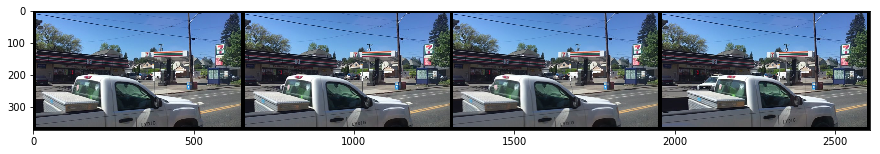

In [0]:
a, b, c = validate()
print(a, b, c.size())
plt.imshow(c.permute(1, 2, 0).numpy())

###To continue training from a checkpoint

In [0]:
if trainingContinue:
    dict1 = torch.load('E:/Super SloMo/Checkpoints/SuperSloMoE6_103.ckpt')
    ArbTimeFlowIntrp.load_state_dict(dict1['state_dictAT'])
    flowComp.load_state_dict(dict2['state_dictFC'])
else:
    dict1 = {'loss': [], 'valLoss': [], 'valPSNR': [], 'epoch': -1}

In [0]:
import time

start = time.time()
cLoss   = dict1['loss']
valLoss = dict1['valLoss']
valPSNR = dict1['valPSNR']
ucfPSNR = dict1['ucfPSNR']
ucfSDev = dict1['ucfSDev']
flag = 1

### Main training loop
for epoch in range(dict1['epoch'] + 1, 200):
    clear_output()
    print(epoch)
    
    #plots
    if (epoch):
        Plot(1, cLoss, 'red')
        Plot(1, valLoss, 'blue')
        Plot(2, valPSNR, 'green')
        Plot(2, ucfPSNR, 'blue')
        display(plt.gcf())
    
    #Init
    cLoss.append([])
    valLoss.append([])
    valPSNR.append([])
    ucfPSNR.append([])
    ucfSDev.append([])
    iLoss = 0
    
    
    for trainIndex, (trainData, trainFrameIndex) in enumerate(trainloader, 0):
        
		## Getting the input and the target from the training set
        frame0, frameT, frame1 = trainData
        
        I0 = frame0.to(device)
        I1 = frame1.to(device)
        IFrame = frameT.to(device)
        
        optimizer.zero_grad()
        flowOut = flowComp(torch.cat((I0, I1), dim=1))
        
        F_0_1 = flowOut[:,:2,:,:]
        F_1_0 = flowOut[:,2:,:,:]
        
        fCoeff = model.getFlowCoeff(trainFrameIndex, device)
        
        #print(C00, C01, C10, C11, t, trainFrameIndex)
        #print(Coeff, trainFrameIndex)
        
        F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
        F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0
        
        
        g_I0_F_t_0 = trainFlowBackWarp(I0, F_t_0)
        g_I1_F_t_1 = trainFlowBackWarp(I1, F_t_1)
        
        
        intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
                
        F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
        F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
        V_t_0   = F.sigmoid(intrpOut[:, 4:5, :, :])
        V_t_1   = 1 - V_t_0
                
        g_I0_F_t_0_f = trainFlowBackWarp(I0, F_t_0_f)
        g_I1_F_t_1_f = trainFlowBackWarp(I1, F_t_1_f)
        
        wCoeff = model.getWarpCoeff(trainFrameIndex, device)
        
        Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
        
        recnLoss = L1_lossFn(Ft_p, IFrame)
            
        prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))
        
        warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(trainFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(trainFlowBackWarp(I1, F_0_1), I0)
        
        loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
        loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
        loss_smooth = loss_smooth_1_0 + loss_smooth_0_1
            
        loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth
        
        loss.backward()
        optimizer.step()
        iLoss += loss.item()
        
        if (flag):
            writer.add_graph(flowComp, flowOut, verbose=True)
            flag = 0        
        
        if ((trainIndex % 100) == 99):
            end = time.time()
            
            psnr, vLoss, valImg = validate()
            
            valPSNR[epoch].append(psnr)
            valLoss[epoch].append(vLoss)
            
            #Tensorboard
            itr = trainIndex + epoch * (len(trainloader))
            
            writer.add_scalars('Loss', {'trainLoss': iLoss/100,
                                        'validationLoss': vLoss}, itr)
            writer.add_scalar('PSNR', psnr, itr)
            writer.add_scalar('standardDev', stdev, itr)
            
            writer.add_image('Validation',valImg , itr)
            #####
            
            endVal = time.time()
            
            print("Loss: %0.6f  Index: %4d  TrainExecTime: %0.1f  ValLoss:%0.6f  ValPSNR: %0.4f  ValEvalTime: %0.2f" % (iLoss / 100, trainIndex, end - start, vLoss, psnr, endVal - end))
            
            
            cLoss[epoch].append(iLoss/100)
            iLoss = 0
            start = time.time()
    
    
    if (1):#(epoch % 10) == 9):
        dict1 = {
                'Detail':"End to end Super SloMo.",
                'epoch':epoch,
                'timestamp':datetime.datetime.now(),
                'trainBatchSz':trainBatchSize,
                'validationBatchSz':validationBatchSize,
                'learningRate':learningRate,
                'loss':cLoss,
                'valLoss':valLoss,
                'valPSNR':valPSNR,
                'state_dictFC': flowComp.state_dict(),
                'state_dictAT': ArbTimeFlowIntrp.state_dict(),
                }
        torch.save(, "E:/Super SloMo/Checkpoints/SuperSloMo_" + str(epoch) + ".ckpt")
    plt.close('all')